# Chapter 17: Decision Trees

'From scratch' work-through following 'Data Science from Scratch'. The plan is to program a decision-tree based script from hand here and later look for pre-made tools in Python and test them on the Titanic dataset from Kaggle.

### Import libraries/modules

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
import math
%matplotlib inline
%matplotlib notebook
from IPython.display import Image
from functools import partial

### Entropy of a data set

Let S be a data set, each member of which is labeled as belonging to one of a finite number of classes $C_1, ..., C_n$. Let $p_i$ be the fraction (probability) of a data point belonging to class $C_i$. Then the **entropy** of the data set is defined as:

\begin{equation}
H(S)=\sum_i -p_i \cdot \log_2 \cdot p_i
\end{equation}

In python, the **entropy function** can be implemented as follows:

In [13]:
def entropy(class_probabilities):
    """given a list of class probabilities, compute the entropy"""
    return sum(-p * math.log(p, 2)
        for p in class_probabilities
        if p) # ignore zero probabilities

The entropy becomes small if $p_i$ is close to zero or one, i.e. the uncertaintly is small. As an example, here's a plot of $-p \cdot \log_2 \cdot p$ between $0$ and $1$:

<IPython.core.display.Javascript object>


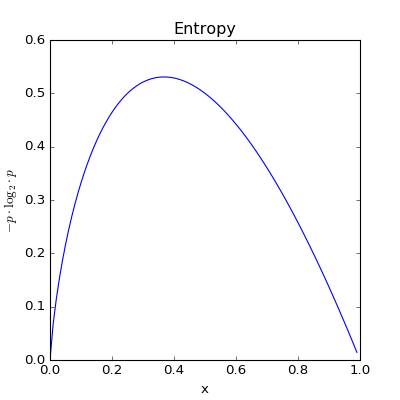

In [10]:
testo = [[i/100,entropy(np.array([i/100]))] for i in range(100)]
testo = np.array(testo)

fig1 = plt.figure(figsize=(5,5))
axes1 = fig1.add_subplot(111)
axes1.plot(testo[:,0],testo[:,1])
axes1.set_xlabel("x")
axes1.set_ylabel("$-p \cdot \log_2 \cdot p$")
axes1.set_title("Entropy")
plt.show()

The data treated with decision trees will consist of pairs (data, label). Note that 'data' here refers for instance to binary attributes. From this, one can compute the class probabilities as follows:

In [4]:
def class_probabilities(labels):
    """Given a set of data points with labels, compute 
    probability distribution."""
    total_count = len(labels)
    class_probabilities = [count/total_count 
                           for count in Counter(labels).values()]
    return class_probabilities

Also write a helper function to extract list of labels from the original data, pass it to 'class_probabilities' and finally compuet entropy from 'entropy'.

In [5]:
def data_entropy(labeled_data):
    """Extract list of labels, calculate class probabilities and finally 
    entropy of the data set."""
    labels = [label for _, label in labeled_data]
    probabilities = class_probabilities(labels)
    H = entropy(probabilities)
    return H

### Entropy of a partition

What the algorithm is supposed to answer is the following question: Given a set of attributes (e.g. the candidate has a PhD, has almost no experience, tweets and likes Python), which label will he have (e.g. will he interview well or not? Here expressed as 'True' and 'False')? The aim is to ask as few questions as possible to get to a definite answer. 

Each question partitions the data into subsets (e.g. does the candidate have a PhD)? Ideally, the question should lead as quickly as possible to the desired answer (does he have the label 'True' or 'False'). This means that the question should result in a partition for which the entropy arising from all the subsets is as small as possible (the best question would be one where the entropy associated with the subsets is zero - i.e. the overall answer is already obtained, since in one subset all labels are 'True' and in all other subsets all labels are 'False'.). Additionally, the entropy arising from each subset of the partition is weighted by the probability that a candidate falls into that partition. 

Mathematically: If we partition the data set $S$ into subsets $S_1,...,S_m$ containing proportions $q_1,...,q_m$ of the data, then we compute the entropy of the partition as weighted sum of the entropies of the subsets:

\begin{equation}
H=q_1H(S_1)+...+q_mH(S_m)
\end{equation}

In [6]:
def partition_entropy(subsets):
    """find the entropy from this partition of data into subsets
    subsets is a list of lists of labeled data"""
    total_count = sum(len(subset) for subset in subsets)
    subset_entropy = sum( data_entropy(subset) * len(subset) / total_count
        for subset in subsets )
    return subset_entropy

NB (from the book): One problem with this approach is that partitioning by an attribute with many different values will result in a very low entropy due to overfitting. For example, imagine you work for a bank and are trying to build a decision tree to predict which of your customers are likely to default on their mortgages, using some historical data as your training set. Imagine further that the data set contains each customer’s Social Security number. Partitioning on SSN will produce one-person subsets, each of which necessarily has zero entropy. But a model that relies on SSN is certain not to generalize beyond the training set. For this reason, you should probably try to avoid (or bucket, if appropriate) attributes with large numbers of possible values when creating decision trees.

### ID3 algorithm

The ID3 algorithm works as follows: Let’s say we’re given some labeled data, and a list of attributes to consider branching on. 
* If the data all have the same label, then create a leaf node that predicts that label and then stop.
* If the list of attributes is empty (i.e., there are no more possible questions to ask), then create a leaf node that predicts the most common label and then stop.
* Otherwise, try partitioning the data by each of the attributes. Choose the partition with the lowest partition entropy. Add a decision node based on the chosen attribute.
* Recur on each partitioned subset using the remaining attributes

NB: ID3 is a **greedy algorithm**, meaning it always looks for the 'best local step' (minimising partition entropy), which might not be the best strategy a few steps down the path.

In [7]:
def partition_by(inputs, attribute):
    """each input is a pair (attribute_dict, label).
    returns a dict : attribute_value -> inputs"""
    groups = defaultdict(list)
    for input in inputs:
        key = input[0][attribute] # get the value of the specified attribute
        groups[key].append(input) # then add this input to the correct list
    return groups

def partition_entropy_by(inputs, attribute):
    """computes the entropy corresponding to the given partition"""
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())

### The Data

Each point of the data set consists of a tuple (dictionary of attributes, label). The attributes are used to ask questions ('Does he have a PhD?') to determine which label the individual data point has (Good interview, coded as: 'True/False'). 

In [8]:
inputs = [
    ({'level':'Senior', 'lang':'Java', 'tweets':'no', 'phd':'no'}, False),
    ({'level':'Senior', 'lang':'Java', 'tweets':'no', 'phd':'yes'}, False),
    ({'level':'Mid', 'lang':'Python', 'tweets':'no', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'Python', 'tweets':'no', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'R', 'tweets':'yes', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'R', 'tweets':'yes', 'phd':'yes'}, False),
    ({'level':'Mid', 'lang':'R', 'tweets':'yes', 'phd':'yes'}, True),
    ({'level':'Senior', 'lang':'Python', 'tweets':'no', 'phd':'no'}, False),
    ({'level':'Senior', 'lang':'R', 'tweets':'yes', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'Python', 'tweets':'yes', 'phd':'no'}, True),
    ({'level':'Senior', 'lang':'Python', 'tweets':'yes', 'phd':'yes'}, True),
    ({'level':'Mid', 'lang':'Python', 'tweets':'no', 'phd':'yes'}, True),
    ({'level':'Mid', 'lang':'Java', 'tweets':'yes', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'Python', 'tweets':'no', 'phd':'yes'}, False)
    ]

### Manual example of how the algorithm works

**Step 1:** Partition the data by the four availalbe attributes and see which partition gives the smallest partition entropy:

In [16]:
for attribute in ['level','lang','tweets','phd']:
    H = partition_entropy_by(inputs,attribute)
    print (attribute,H)

level 0.6935361388961919
lang 0.8601317128547441
tweets 0.7884504573082896
phd 0.8921589282623617


The lowest partition entropy arises when branching on 'level', which we thus select as the first step. 

**Step 2:** Next, we need to partition entropy of the three potential sub-trees, i.e. all data points for which the attribute 'level' equals 'junior', 'medium' and 'senior' respectively.

In [26]:
# partition entropy for 'Junior' level:
junior_inputs = [(attributes,label) for attributes,label in inputs if attributes['level']=='Junior']
print ('Junior level:')
for attribute in ['lang','tweets','phd']:
    H = partition_entropy_by(junior_inputs,attribute)
    print (attribute,H)

mid_inputs = [(attributes,label) for attributes,label in inputs if attributes['level']=='Mid']
print ('')
print ('Mid level:')
for attribute in ['lang','tweets','phd']:
    H = partition_entropy_by(mid_inputs,attribute)
    print (attribute,H)
    
senior_inputs = [(attributes,label) for attributes,label in inputs if attributes['level']=='Senior']
print ('')
print ('Senior level:')
for attribute in ['lang','tweets','phd']:
    H = partition_entropy_by(senior_inputs,attribute)
    print (attribute,H)

Junior level:
lang 0.9509775004326938
tweets 0.9509775004326938
phd 0.0

Mid level:
lang 0.0
tweets 0.0
phd 0.0

Senior level:
lang 0.4
tweets 0.0
phd 0.9509775004326938


On the junior level, branching on 'phd' gives zero entropy (all junior data scientists with a PhD interviewed badly...). On the mid level, all choices give zero entropy, so this is already a leafe node (predicting 'True'). Finally, senior candidates can be assigned by tweeting, thus finishing the overall decision tree:

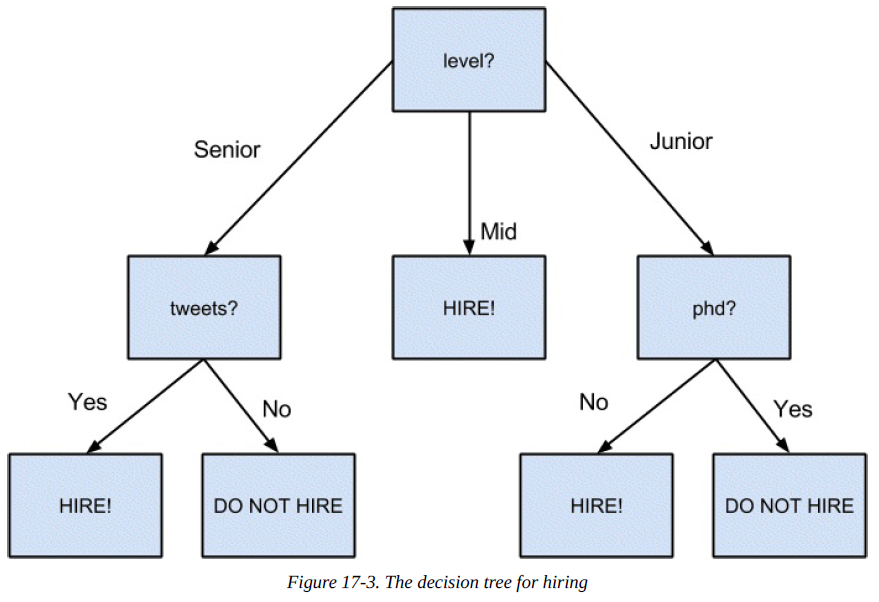

In [29]:
Image(filename='decision_tree_example.png')

### Representing decision trees

(From the book): 'We’ll use pretty much the most lightweight representation possible. We define a tree to be one of the following:

* True
* False
* a tuple (attribute, subtree_dict)

Here True represents a leaf node that returns True for any input, False represents a leaf node that returns False for any input, and a tuple represents a decision node that, for any input, finds its attribute value, and classifies the input using the corresponding subtree. With this representation, our hiring tree would look like:

~~~python
    ('level',
        {'Junior': ('phd', {'no': True, 'yes': False}),
        'Mid': True,
        'Senior': ('tweets', {'no': False, 'yes': True})})
~~~

There’s still the question of what to do if we encounter an unexpected (or missing) attribute value. What should our hiring tree do if it encounters a candidate whose level is “Intern”? We’ll handle this case by adding a None key that just predicts the most common label.

### Creating a decision tree from training data

In the end, we would like to automatically create a decision tree from the training data and then apply it to predict the label of new data points. 

Here's a function to build a tree of the above structure from the training data set:

In [35]:
def build_tree_id3(inputs, split_candidates=None):
    # if this is our first pass,
    # all keys of the first input are split candidates
    # otherwise use only the remaining attributes
    if split_candidates is None:
        # obtain list of attributes from first candidate
        split_candidates = inputs[0][0].keys()
    
    # count Trues and Falses in the inputs
    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label])
    num_falses = num_inputs - num_trues
    
    # if at a leaf node, make a prediction
    if num_trues == 0: return False # no Trues? return a "False" leaf
    if num_falses == 0: return True # no Falses? return a "True" leaf
   
    # if no questions to ask remain, make a prediction based on majority of labels
    if not split_candidates: # if no split candidates left
        return num_trues >= num_falses # return the majority leaf
    
    # otherwise, split on the best attribute
    best_attribute = min(split_candidates, key=partial(partition_entropy_by, inputs))
    
    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates if a != best_attribute]
    
    # recursively build the subtrees
    subtrees = { attribute_value : build_tree_id3(subset, new_candidates) 
                for attribute_value, subset in partitions.items() }
    
    subtrees[None] = num_trues > num_falses # default case
    return (best_attribute, subtrees)

In [38]:
tree_1 = build_tree_id3(inputs)

### Applying decision tree to new candidates

In [41]:
def classify(tree, input):
    """classify the input using the given decision tree"""
    # if this is a leaf node, return its value
    if tree in [True, False]:
        return tree
    # otherwise this tree consists of an attribute to split on
    # and a dictionary whose keys are values of that attribute
    # and whose values of are subtrees to consider next
    attribute, subtree_dict = tree
    subtree_key = input.get(attribute) # None if input is missing attribute
    if subtree_key not in subtree_dict: # if no subtree for key,
        subtree_key = None # we'll use the None subtree
    subtree = subtree_dict[subtree_key] # choose the appropriate subtree
    return classify(subtree, input) # and use it to classify the input

Note that a new candidate is simply represented by a dictionary, since we do not have a label yet:

In [42]:
new_candidate = { "level" : "Junior", "lang" : "Java", "tweets" : "yes", "phd" : "no"}

In [43]:
classify(tree_1,new_candidate)

True

### Random forests

* Problem of overfitting
* random bootstrapping (kFolds) for training, voting on stuff...